In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

In [4]:
import numpy as np   
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import librosa
import tensorflow as tf 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Bidirectional

In [5]:
def load_and_preprocess_data(audio_path,label):
    audio,sr = librosa.load(audio_path,sr=16000,mono=True)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return mfccs.T, label

def prepare_dataset(real_paths, fake_paths):
    X, y = [], []

    for path in real_paths:
        audio, sr = librosa.load(path, sr=16000)
        mfcc_augments = augment_data(audio, sr)
        for mfcc in mfcc_augments:
            X.append(mfcc)
            y.append(0)  # Label for real

    for path in fake_paths:
        audio, sr = librosa.load(path, sr=16000)
        mfcc_augments = augment_data(audio, sr)
        for mfcc in mfcc_augments:
            X.append(mfcc)
            y.append(1)  # Label for fake

    return X, np.array(y)

In [6]:
def augment_data(audio, sr):
    augmented = []

    # Original
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13).T
    augmented.append(mfcc)

    # Time-stretch
    stretched = librosa.effects.time_stretch(audio, rate=0.8)
    mfcc_stretch = librosa.feature.mfcc(y=stretched, sr=sr, n_mfcc=13).T
    augmented.append(mfcc_stretch)

    # Pitch shift
    shifted = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    mfcc_shift = librosa.feature.mfcc(y=shifted, sr=sr, n_mfcc=13).T
    augmented.append(mfcc_shift)

    return augmented


In [7]:
def create_model(input_shape):
    model = Sequential([
    Input(shape=input_shape),
    Masking(mask_value=0.),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')
])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [8]:
def train_and_evaluate(model,X_train,y_train,X_test,y_test,epochs=50,batch_size=16):
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2,verbose=2)
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print(f'\nTest accuracy: {test_acc}')


    return history

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
import os

In [12]:
base_path = '/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO'
print("Checking REAL folder:", os.path.exists(os.path.join(base_path, "REAL")))
print(os.getcwd())

Checking REAL folder: True
/kaggle/working


In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,Masking

In [14]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 2


(192, 23438, 13)


I0000 00:00:1746950540.884540      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746950540.885247      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1746950549.182759     127 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 - 21s - 3s/step - accuracy: 0.8852 - loss: 0.3956 - val_accuracy: 0.8710 - val_loss: 0.3617
Epoch 2/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.3480 - val_accuracy: 0.8710 - val_loss: 0.3594
Epoch 3/50
8/8 - 12s - 2s/step - accuracy: 0.8852 - loss: 0.3355 - val_accuracy: 0.8710 - val_loss: 0.3541
Epoch 4/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.3048 - val_accuracy: 0.8710 - val_loss: 0.3356
Epoch 5/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.2954 - val_accuracy: 0.8710 - val_loss: 0.3239
Epoch 6/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.2681 - val_accuracy: 0.8710 - val_loss: 0.3205
Epoch 7/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.2304 - val_accuracy: 0.8710 - val_loss: 0.3220
Epoch 8/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.2011 - val_accuracy: 0.8710 - val_loss: 0.3278
Epoch 9/50
8/8 - 13s - 2s/step - accuracy: 0.8852 - loss: 0.1829 - val_accuracy: 0.8710 - val_loss: 0.3541
Epoch 10/50
8/8 - 13s - 2s/step - accuracy: 0.88

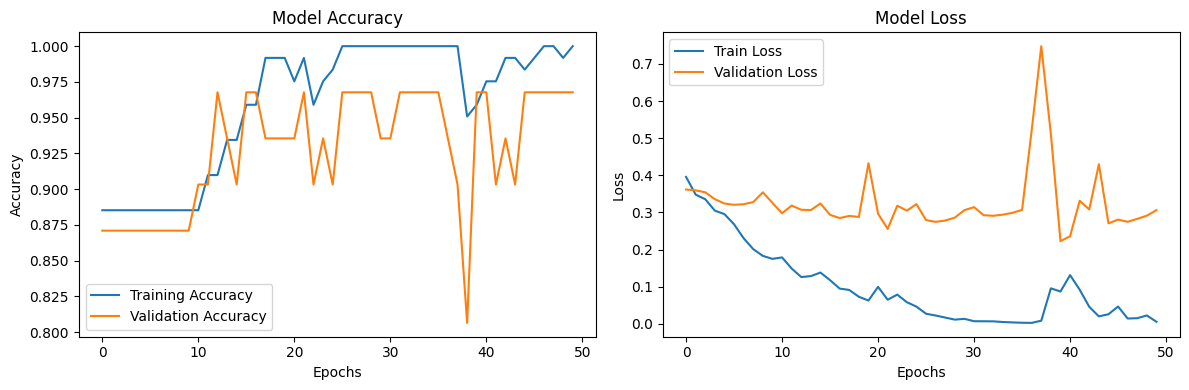

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


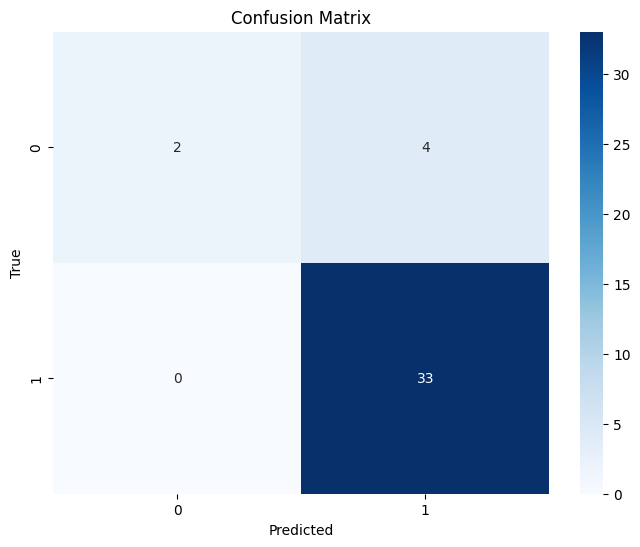

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         6
           1       0.89      1.00      0.94        33

    accuracy                           0.90        39
   macro avg       0.95      0.67      0.72        39
weighted avg       0.91      0.90      0.87        39



In [16]:
real_paths = [os.path.join(base_path, "REAL", f) for f in os.listdir(os.path.join(base_path, "REAL")) if f.endswith('.wav')]
fake_paths = [os.path.join(base_path, "FAKE", f) for f in os.listdir(os.path.join(base_path, "FAKE")) if f.endswith('.wav')]

X, y = prepare_dataset(real_paths, fake_paths)


max_length = int(np.quantile([len(seq) for seq in X], 0.95))  # Safer cutoff
X_padded = pad_sequences(X, maxlen=max_length, dtype='float32', padding='post', truncating='post')
print(X_padded.shape)

X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

with tf.device('/GPU:0'):
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    history = train_and_evaluate(model, X_train, y_train, X_test, y_test)

plot_training_history(history)
y_pred = model.predict(X_test)
plot_confusion_matrix(y_test, y_pred)

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

In [17]:
!pip install librosa

In [20]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13807861352835921419
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9895196098939164150
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 14619377664
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 10888181151212274306
physical_device_desc: "device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
xla_global_id: 2144165316
]


I0000 00:00:1746886168.030753      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746886168.031018      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [18]:
import librosa
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def preprocess_audio(audio_path, max_length):
    audio, sr = librosa.load(audio_path, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    mfccs = mfccs.T
    padded_mfccs = pad_sequences([mfccs], maxlen=max_length, dtype='float32', padding='post', truncating='post')
    return padded_mfccs

In [20]:
test_audio_paths = ['/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav']

for audio_path in test_audio_paths:
    padded_sample = preprocess_audio(audio_path, max_length=X_train.shape[1])
    prediction = model.predict(padded_sample)
    predicted_class = np.argmax(prediction, axis=1)[0]
    
    if predicted_class == 1:
        print(f"The audio {audio_path} is predicted as FAKE.")
    else:
        print(f"The audio {audio_path} is predicted as REAL.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
The audio /kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/biden-original.wav is predicted as REAL.
